### OPL and ray tracing calculation for a system with tilted coverslip

1. Coordinate system: XY
  * X is the optical axis of objective, 
  * x=0 at the sample|coverslip boundary

2. units: mm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_sample = 1.3325 #water: 1.33; life worm: 1.37; fixed and mounted in ProLong Gold: 1.47
# n= 1.37 @ 633 nm is C.elegans RI, ref: https://www.ncbi.nlm.nih.gov/pubmed/17694065/
n_glass = 1.5230 #@589 nm, D263M borosilicate glass for coverslips, from Fischer Scientific datasheet
n_media = 1.3325 #water (1.3325), glycerol(1.4722), immersion oil (1.515)
n_mediaArray = np.array([1.3325, 1.4722, 1.515]) #water, glycerol, immersion oil
mediaLabel = ['water','glycerol', 'oil']

tilt_angle = 45./180*np.pi #45-degree tilt of coverslip
thickness_glass = 0.170 #mm, No1.5 standard glass

thetaRadArray = np.linspace(-36.9,36.9,21)/180.0*np.pi ##ray angle from the point source

NA = np.sin(thetaRadArray[-1])*n_media #max NA of the system, using sample refractive index
print 'max NA = ' + str(NA)

max NA = 0.8000599502467403


In [3]:
tilt_angle

0.7853981633974483

Two surfaces of the coverslip

In [4]:
def S1(x,tilt = 0.7853981633974483):
    """ first glass surface, closer to the sample. Default tilt 0.7853981633974483 rad is 45 deg. """
    return x*np.tan(tilt)

def S2(x,tilt = 0.7853981633974483,th_glass = 0.17):
    return x * np.tan(tilt) - th_glass/np.cos(tilt)

In [5]:
def ray_tracing(x0,y0,theta0, tilt, n_sample, n_glass, n_media, th_glass):
    """ Tracing of a ray emanating from point (x0,y0) at angle theta0 using Snell's law
    through tilted glass of thickness th_glass into immersion media, up to x3 axial position
    refr. indices: n_sample, n_glass, n_media,
    """
    # first refraction point
    x1 = x0 * np.tan(theta0)/(np.tan(theta0) - np.tan(tilt))
    y1 = S1(x1, tilt)
    theta1 = np.arcsin(n_sample/n_glass*np.sin(tilt + theta0)) - tilt
    # second refr. point
    x2 = x1 - th_glass/(np.cos(tilt)*(np.tan(theta1) - np.tan(tilt)))
    y2 = S2(x2,tilt,th_glass)
    theta2 = np.arcsin(n_glass/n_media * np.sin(tilt + theta1)) - tilt
    return (x1,y1,theta1, x2,y2,theta2)

Plot the ray fan.

Ignore invalid value warining in arcsin(), this is due to total internal reflection, these rays become 'nan' 

Text(0.8,0.4,'water')

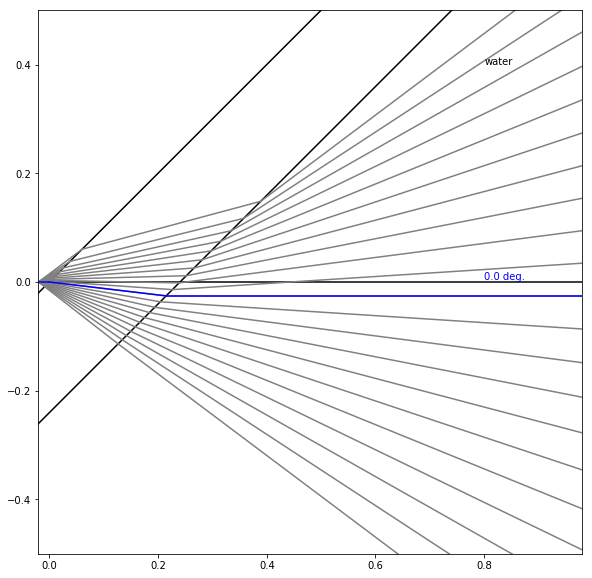

In [6]:
source_posX_mm = -0.02
source_posY_mm = 0
i_medium = 0 #water

fig, ax = plt.subplots(1,1,figsize = (10,10))
x_min = -0.1
x_max = 1.
axialRayInd = np.where(thetaRadArray == 0)[0]

ax.plot([x_min, x_max],[S1(x_min), S1(x_max)],'-k')
ax.plot([x_min, x_max],[S2(x_min), S2(x_max)],'-k')
ax.axhline(y=0, color='k')
ax.set_aspect('equal', 'box')
x0, y0 = source_posX_mm, source_posY_mm
(x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                  n_sample, n_glass, n_mediaArray[i_medium], thickness_glass)
x3 = x_max*np.ones(len(thetaRadArray))
y3 = y3 = y2 + (x3-x2)*np.tan(theta2)
#plot all rays
ax.plot([x0*np.ones(len(thetaRadArray)), x1], [y0*np.ones(len(thetaRadArray)), y1],color = 'gray')
ax.plot([x1, x2], [y1, y2],color = 'gray')
ax.plot([x2, x3], [y2, y3],color = 'gray')
#plot axial ray
ax.plot([x0, x1[axialRayInd]], [y0, y1[axialRayInd]],color = 'blue')
ax.plot([x1[axialRayInd], x2[axialRayInd]], [y1[axialRayInd], y2[axialRayInd]],color = 'blue')
ax.plot([x2[axialRayInd], x3[axialRayInd]], [y2[axialRayInd], y3[axialRayInd]],color = 'blue')
# print axis ray angle, deg.
ax.text(0.8, y3[axialRayInd]+0.03, '{:2.1f}'.format(theta2[axialRayInd][0]/np.pi*180) + ' deg.',color='blue')
ax.set_xlim([-0.02, 0.98])
ax.set_ylim([-0.5, 0.5])
ax.text(0.8,0.4,mediaLabel[i_medium])

Find where rays reach the reference sphere (R_refSphere)

In [7]:
def intersectRefSphere(x0,y0,x2,y2,theta2,r):
    """Solve quadratic equation to find where ray3 intersects ref. sphere"""
    a = 1.0 + np.tan(theta2)**2
    b = 2.0*y2*np.tan(theta2) - 2.0*x2*np.tan(theta2)**2 - 2.0*x0
    c = (y2 - y0 - x2*np.tan(theta2))**2 - r**2 + x0**2
    x3_refSphere = (-b + np.sqrt(b**2 - 4.0*a*c))/(2*a)
    y3_refSphere = y2 + (x3_refSphere - x2)*np.tan(theta2)
    return (x3_refSphere, y3_refSphere)

In [8]:
def ref_sphere(x0, y0, r):
    """Generates x,y pairs for drawing a sphere"""
    theta = np.linspace(0,2*np.pi,100)
    return (x0 + r*np.cos(theta), y0 + r*np.sin(theta))

Text(0.5,1,'x0, mm: -0.02')

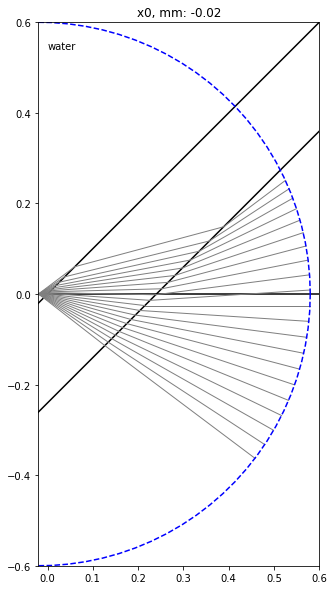

In [35]:
i_medium = 0 #water
n_media = n_mediaArray[i_medium]
x0, y0 = source_posX_mm, source_posY_mm
R_refSphere_mm = 0.6

fig, ax = plt.subplots(1,1,figsize = (10,10))
x_min = -0.1
x_max = R_refSphere_mm
ax.plot([x_min, x_max],[S1(x_min), S1(x_max)],'-k')
ax.plot([x_min, x_max],[S2(x_min), S2(x_max)],'-k')
ax.axhline(y=0, color='k')
ax.set_aspect('equal', 'box')

(x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                  n_sample, n_glass, n_mediaArray[i_medium], thickness_glass)

(x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2,theta2,R_refSphere_mm)
ax.plot([x0*np.ones(len(thetaRadArray)), x1], [y0*np.ones(len(thetaRadArray)), y1],color = 'gray',lw = 1)
ax.plot([x1, x2], [y1, y2],color = 'gray',lw = 1)
ax.plot([x2, x3_refSphere], [y2, y3_refSphere],color = 'gray',lw = 1)

(x_sphere,y_sphere) = ref_sphere(x0, y0, R_refSphere_mm)
ax.plot(x_sphere,y_sphere, '--b')
ax.set_xlim([x0, x_max])
ax.set_ylim([-R_refSphere_mm, R_refSphere_mm])
ax.text(0, R_refSphere_mm*0.9, mediaLabel[i_medium])
ax.set_title('x0, mm: ' + str(x0))

## Plot iso-OPL lines 

In [50]:
#for a given OPL value (mm), find (x_iso, y_iso) coordinates where this OPL is reached, for every ray.
opl_max_mm = 1
opl_vacuum_mm_array = np.linspace(0.01, opl_max_mm, 20)
x_iso_opl = np.zeros((len(opl_vacuum_mm_array),len(thetaRadArray)))
y_iso_opl = np.zeros((len(opl_vacuum_mm_array),len(thetaRadArray)))

for i_opl in range(len(opl_vacuum_mm_array)):
    for i_ray in range(len(thetaRadArray)):
        opl_mm = opl_vacuum_mm_array[i_opl]
        opl_in_sample = n_sample*np.sqrt((x1[i_ray] - x0)**2 + (y1[i_ray] - y0)**2)
        opl_in_glass = n_glass*np.sqrt((x2[i_ray] - x1[i_ray])**2 + (y2[i_ray] - y1[i_ray])**2)
        if opl_mm <= opl_in_sample:
            #record coordinates in sample
            x_iso_opl[i_opl,i_ray] = x0 + opl_mm/n_sample*np.cos(thetaRadArray[i_ray])
            y_iso_opl[i_opl,i_ray] = y0 + opl_mm/n_sample*np.sin(thetaRadArray[i_ray])
        elif opl_mm <= opl_in_sample + opl_in_glass:
            #record coords in glass
            x_iso_opl[i_opl,i_ray] = x1[i_ray] + (opl_mm - opl_in_sample)/n_glass*np.cos(theta1[i_ray])
            y_iso_opl[i_opl,i_ray] = y1[i_ray] + (opl_mm - opl_in_sample)/n_glass*np.sin(theta1[i_ray])
        else:
            #record coords in immersion medium
            x_iso_opl[i_opl,i_ray] = x2[i_ray] + (opl_mm - opl_in_sample - opl_in_glass)/n_media*np.cos(theta2[i_ray])
            y_iso_opl[i_opl,i_ray] = y2[i_ray] + (opl_mm - opl_in_sample - opl_in_glass)/n_media*np.sin(theta2[i_ray])
        

Text(0.5,1,'x0, mm: -0.02')

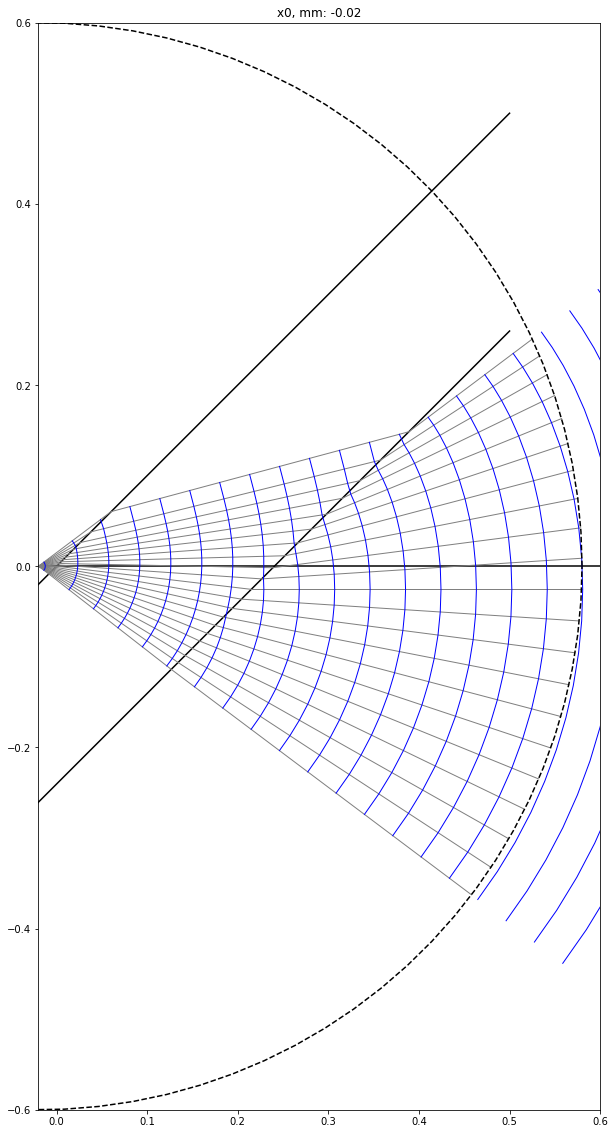

In [51]:
fig, ax = plt.subplots(1,1,figsize = (20,20))
x_min = -0.1
x_max = 0.5
ax.plot([x_min, x_max],[S1(x_min), S1(x_max)],'-k')
ax.plot([x_min, x_max],[S2(x_min), S2(x_max)],'-k')
ax.axhline(y=0, color='k')
ax.set_aspect('equal', 'box')

ax.plot([x0*np.ones(len(thetaRadArray)), x1], [y0*np.ones(len(thetaRadArray)), y1],color = 'gray',lw = 1)
ax.plot([x1, x2], [y1, y2],color = 'gray',lw = 1)
ax.plot([x2, x3_refSphere], [y2, y3_refSphere],color = 'gray',lw = 1)
ax.plot(x_iso_opl.T, y_iso_opl.T, '-b',lw = 1)

(x_sphere,y_sphere) = ref_sphere(x0, y0, R_refSphere_mm)
ax.plot(x_sphere,y_sphere, '--k')

ax.set_xlim([x0, R_refSphere_mm])
ax.set_ylim([-R_refSphere_mm, R_refSphere_mm])
ax.set_title('x0, mm: ' + str(x0))

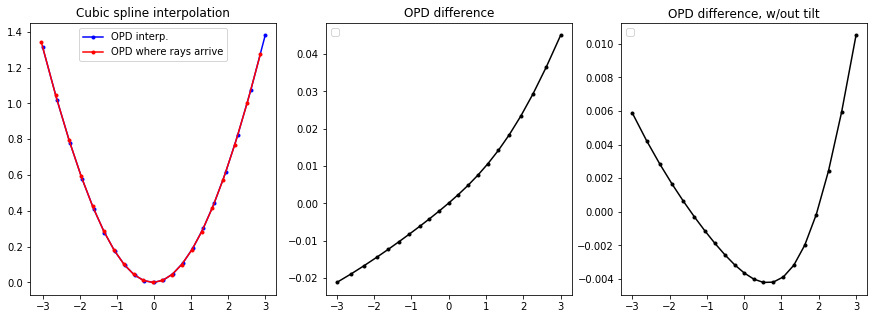

In [69]:
fig, ax = plt.subplots(1,3,figsize = (15,5))

ax[0].plot(y_rays_plane_no_coverslip, OPD_coverslip_interp, '.-b', label = 'OPD interp.')
ax[0].plot(y3_ref_plane_coverslip, OPD_ref_plane_coverslip, '.-r', label = 'OPD where rays arrive')
ax[0].set_title("Cubic spline interpolation")
ax[0].legend()

ax[1].plot(y_rays_plane_no_coverslip, OPD_coverslip_interp - OPD_ref_plane_no_coverslip, '.-k')
ax[1].set_title("OPD difference")
ax[1].legend()

tilt_y_poly = np.poly1d(np.polyfit(y_rays_plane_no_coverslip, OPD_coverslip_interp - OPD_ref_plane_no_coverslip, 1))
ax[2].plot(y_rays_plane_no_coverslip, OPD_coverslip_interp - OPD_ref_plane_no_coverslip \
           - tilt_y_poly(y_rays_plane_no_coverslip), '.-k')
ax[2].set_title("OPD difference, w/out tilt")
ax[2].legend()